# Simple molecular dynamics simmulation of argon gas
- ogiginal version: https://github.com/basnijholt/molecular-dynamics-Python

In [20]:
import numpy as np
from itertools import product
rho = .88 # density of Argon in natural units
dt = 0.004 # time step size
T_0 = 1.0 # temperature
N_cell = 3 # number of unitcells in one direction    
N = 4 * N_cell ** 3 # the total number of particles in the system
L_box = (N / rho) ** (1 / 3) # length of the whole box
L_cell = L_box / N_cell # length of a unitcell
F = np.zeros((N, N, 3)) # matrix that contains all forces
ind = np.triu_indices(N, k=1) # indices of upper triangular matrix
bins = 30

In [21]:
def IC_pos(N_cell, L_cell):
    pos = [[[x,  y, z], [x, 0.5 + y, 0.5 + z], [0.5 + x, y, 0.5 + z], [0.5 + x, 0.5 + y, z]] 
           for x, y, z in product(range(N_cell), range(N_cell), range(N_cell))]
    pos = np.array(pos).reshape((-1, 3))
    return pos * L_cell


def IC_vel(N):
    vel = np.random.randn(N, 3)
    vel -= np.average(vel, axis=0)
    return vel 


def find_force(pos, L_box=L_box):
    r_vec = pos[ind[0]] - pos[ind[1]]
    r_vec = r_vec - np.rint(r_vec / L_box) * L_box
    r_sq = np.sum(r_vec**2, axis=1)
    F_vec = -(48 / r_sq ** 7 - 24 / r_sq ** 4)[:, None] * r_vec
    F[ind[0], ind[1]] = F_vec
    pot = np.sum(4 / r_sq ** 6 - 4 / r_sq ** 3)
    P = np.sum(F_vec * r_vec)
    hist = np.histogram(r_sq, bins=bins, range=(0, L_box / 2))[0]
    return np.sum(F, axis=0) - np.sum(F, axis=1), pot, P, hist


def time_step(pos, vel, F):
    vel += 0.5 * F * dt
    pos = np.mod(pos + vel * dt, L_box)
    F, pot, P, hist = find_force(pos)
    
    vel += 0.5 * F * dt
    kin = 0.5 * np.sum(vel**2)
    return pos, vel, F, pot, kin, P, hist

In [58]:
def simulate():
    kins, pots, Ps, hists, temps = [], [], [], [], []
    pos = IC_pos(N_cell, L_cell)
    
    # set initial velocities to correspond temperature
    vel = IC_vel(N)
    F = find_force(pos)[0]
    pos, vel, F, pot, kin, P, hist = time_step(pos, vel, F)
    vel *= np.sqrt(N * 3 * T_0 / (2 * kin))
    
    F = find_force(pos)[0]
    transientLen = 0 # leave out first few steps as transient
    instTempLen = 1 # length for instanteneous temperature calculation
    for t in range(1000):
        pos, vel, F, pot, kin, P, hist = time_step(pos, vel, F)
        if t > transientLen:
            kins.append(kin)
            pots.append(pot)
            Ps.append(P)
            hists.append(hist)
        if(len(kins)>instTempLen):
            T = np.mean(np.array(kins[max(0,len(kins)-10):len(kins)]) * 2 / (3 * N))
            temps.append(T)
        #else:
        #    vel *= np.sqrt(N * 3 * T_0 / (2 * kin))
    return np.array(kins), np.array(pots), np.array(Ps), np.mean(hists, axis=0), np.array(temps)

kins, pots, Ps, hist, temps = simulate()

T = np.mean(kins * 2 / (3 * N))
P = 1 - np.mean(Ps) / (3 * N * T) - 16 * np.pi * rho / (3 * T * L_box**3)

Final temperature is 0.5429
Final Pressure is -4.106


:Overlay
   .Curve.Kinetic_energy   :Curve   [x]   ($E$)
   .Curve.Potential_energy :Curve   [x]   ($E$)
   .Curve.Total_energy     :Curve   [x]   ($E$)
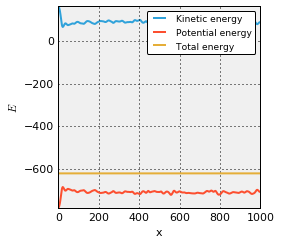

In [59]:
import holoviews as hv
hv.notebook_extension('matplotlib')

print("Final temperature is {:.4}".format(T))
print("Final Pressure is {:.4}".format(P))
      
(hv.Curve(kins, label='Kinetic energy', vdims=[r'$E$']) * 
 hv.Curve(pots, label='Potential energy', vdims=[r'$E$']) * 
 hv.Curve(pots + kins, label='Total energy', vdims=[r'$E$']))

b':Curve   [x]   ($T$)'
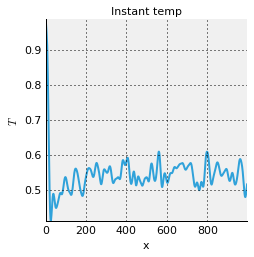

In [60]:
(hv.Curve(temps, label='Instant temp', vdims=[r'$T$']) )

b':Path   [$r$,$g(r)$]'
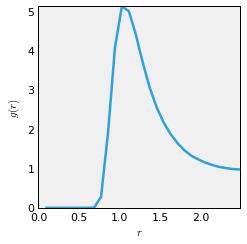

In [14]:
%%opts Path [aspect='square']
r = np.linspace(0, L_box / 2, bins)
pair_correlation = hist / (4 * np.pi * rho * r)
hv.Path((r, pair_correlation), kdims=[r'$r$', r'$g(r)$'])